In [1]:
import os
import json
import pandas as pd

# If using Kaggle API, you can use the dataset directly by setting up the kaggle.json file
# Ensure you've uploaded the kaggle.json file containing API credentials into the environment.
# Use Kaggle API to download the dataset if needed (as an alternative to direct upload)

# If you already have the file loaded, use it:
file_path = '/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json'  # Replace with your actual file path

# Load data into DataFrame
def load_data(file_path):
    """
    Load JSON data and convert to pandas DataFrame.
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        data = [json.loads(line) for line in file]
    return pd.DataFrame(data)

# Load the dataset
reviews_df = load_data(file_path)

# Display basic info about dataset
print(reviews_df.info())
print(reviews_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   review_id    object 
 1   user_id      object 
 2   business_id  object 
 3   stars        float64
 4   useful       int64  
 5   funny        int64  
 6   cool         int64  
 7   text         object 
 8   date         object 
dtypes: float64(1), int64(3), object(5)
memory usage: 480.0+ MB
None
                review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4  Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   

   stars  useful  funny  cool  \
0    3.0       0      0     0   
1   

In [2]:
# Label positive (4-5 stars) and negative (1-2 stars)
def label_sentiment(stars):
    if stars >= 4:
        return 'positive'
    elif stars <= 2:
        return 'negative'
    else:
        return 'neutral'  # Optional: If you want to include neutral, otherwise filter it out

# Apply sentiment labeling
reviews_df['sentiment'] = reviews_df['stars'].apply(label_sentiment)

# Filter out neutral reviews (optional based on your analysis requirement)
reviews_df = reviews_df[reviews_df['sentiment'] != 'neutral']

# Balance the classes (for faster training)
positive_reviews = reviews_df[reviews_df['sentiment'] == 'positive']
negative_reviews = reviews_df[reviews_df['sentiment'] == 'negative']

# Randomly sample to limit to 200,000 total samples (balanced)
positive_sample = positive_reviews.sample(n=100000, random_state=42)
negative_sample = negative_reviews.sample(n=100000, random_state=42)

# Combine the balanced sample
reviews_df = pd.concat([positive_sample, negative_sample])

print(f"Balanced dataset shape: {reviews_df.shape}")

Balanced dataset shape: (200000, 10)


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization with a maximum of 25 features
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf_vectorizer.fit_transform(reviews_df['text'])

print("Shape of the feature matrix:", X.shape)
print("Top 25 features:", tfidf_vectorizer.get_feature_names_out())

Shape of the feature matrix: (200000, 5000)
Top 25 features: ['00' '000' '00pm' ... 'zone' 'zoo' 'zucchini']


In [4]:
from sklearn.decomposition import PCA
import joblib

# Reduce dimensionality to 50 components (adjust if needed for faster results)
pca = PCA(n_components=50, random_state=42)

# Fit and transform the TF-IDF data
X_reduced = pca.fit_transform(X.toarray())
# Save the PCA model
joblib.dump(pca, 'pca_model.pkl')

print(f"Reduced feature matrix shape: {X_reduced.shape}")

Reduced feature matrix shape: (200000, 50)


In [5]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# Apply MiniBatchKMeans clustering
kmeans = MiniBatchKMeans(n_clusters=5, max_iter=100, tol=0.01, batch_size=5000, random_state=42)
clusters = kmeans.fit_predict(X_reduced)

# Evaluate clustering quality using silhouette score
sil_score = silhouette_score(X_reduced, clusters)
print(f"Silhouette Score: {sil_score}")

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.03838642376126419


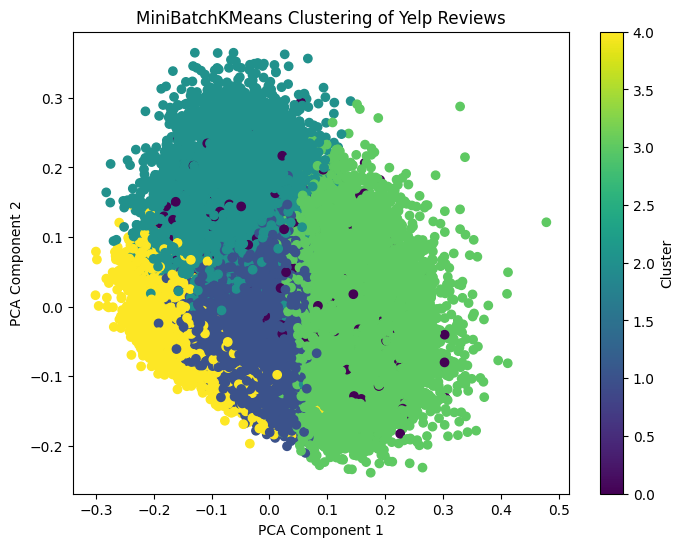

In [6]:
import matplotlib.pyplot as plt

# Reduce the dimensionality to 2 components for visualization
pca_2d = PCA(n_components=2, random_state=42)
reduced_data = pca_2d.fit_transform(X_reduced)

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('MiniBatchKMeans Clustering of Yelp Reviews')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [7]:
import joblib

# Save the MiniBatchKMeans model and TF-IDF vectorizer
joblib.dump(kmeans, 'minibatch_kmeans_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

# Save the predictions
predictions_df = pd.DataFrame({'review_id': reviews_df['review_id'], 'cluster': clusters})
predictions_df.to_csv('clustering_predictions.csv', index=False)

In [9]:
from sklearn.model_selection import train_test_split
# Assuming 'sentiment' is the target column and 'X_reduced' is the feature matrix
y = reviews_df['sentiment']  # Target labels (positive/negative)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Check the shape of the training and testing data
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (160000, 50)
Test set shape: (40000, 50)


In [10]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg.fit(X_train, y_train)

# Predictions on the test set
y_pred = logreg.predict(X_test)

# Output prediction results
print("Predictions on test data:", y_pred[:10])  # Display first 10 predictions

Predictions on test data: ['negative' 'positive' 'negative' 'positive' 'positive' 'positive'
 'negative' 'negative' 'negative' 'positive']


In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.91      0.90     20007
    positive       0.91      0.90      0.90     19993

    accuracy                           0.90     40000
   macro avg       0.90      0.90      0.90     40000
weighted avg       0.90      0.90      0.90     40000

Confusion Matrix:
[[18217  1790]
 [ 2073 17920]]


In [12]:
import joblib
import os

# Kaggle output folder path (Kaggle automatically stores output here)
save_dir = '/kaggle/working'

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the MiniBatchKMeans model
joblib.dump(kmeans, os.path.join(save_dir, 'minibatch_kmeans_model.pkl'))

# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, os.path.join(save_dir, 'tfidf_vectorizer.pkl'))

# Save the Logistic Regression model
joblib.dump(logreg, os.path.join(save_dir, 'logistic_regression_model.pkl'))

# Save the feature matrix (X_reduced) and target labels (y)
joblib.dump(X_reduced, os.path.join(save_dir, 'X_reduced.pkl'))
joblib.dump(y, os.path.join(save_dir, 'y_labels.pkl'))

# Save clustering predictions (for review)
predictions_df = pd.DataFrame({'review_id': reviews_df['review_id'], 'cluster': clusters})
predictions_df.to_csv(os.path.join(save_dir, 'clustering_predictions.csv'), index=False)

print(f"Models and data have been saved to {save_dir}")

Models and data have been saved to /kaggle/working


In [13]:
import joblib
import numpy as np

# Load the saved models and vectorizers
logreg = joblib.load('logistic_regression_model.pkl')
kmeans = joblib.load('minibatch_kmeans_model.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
pca = joblib.load('pca_model.pkl')  # Load the saved PCA model

# Sentiment analysis function
def sentiment_predictions(text):
    text_transformed = tfidf_vectorizer.transform([text])
    
    # Apply PCA using the loaded PCA model
    text_reduced = pca.transform(text_transformed.toarray())

    sentiment = logreg.predict(text_reduced)[0]
    return sentiment

# Clustering function
def cluster_predictions(text):
    text_transformed = tfidf_vectorizer.transform([text])
    
    # Apply PCA using the loaded PCA model
    text_reduced = pca.transform(text_transformed.toarray())

    cluster = kmeans.predict(text_reduced)[0]
    return cluster

# Sample test function
def run_sample_tests():
    sample_texts = [
        "The food was amazing, the service was excellent, and I had a great time!",
        "Worst experience ever, I will never come back to this restaurant.",
        "It was an average experience. The food was okay but the service could be better.",
        "I love this place, the ambiance is perfect, and the staff is friendly!"
    ]
    
    for text in sample_texts:
        print(f"Text: {text}")
        
        # Sentiment Prediction
        sentiment = sentiment_predictions(text)
        print(f"Sentiment Prediction: {sentiment}")
        
        # Cluster Prediction
        cluster = cluster_predictions(text)
        print(f"Cluster Prediction: {cluster}")
        print("-" * 50)

# Run the sample test function
if __name__ == "__main__":
    run_sample_tests()

Text: The food was amazing, the service was excellent, and I had a great time!
Sentiment Prediction: positive
Cluster Prediction: 3
--------------------------------------------------
Text: Worst experience ever, I will never come back to this restaurant.
Sentiment Prediction: negative
Cluster Prediction: 1
--------------------------------------------------
Text: It was an average experience. The food was okay but the service could be better.
Sentiment Prediction: negative
Cluster Prediction: 3
--------------------------------------------------
Text: I love this place, the ambiance is perfect, and the staff is friendly!
Sentiment Prediction: positive
Cluster Prediction: 3
--------------------------------------------------
